In [1]:
import pandas as pd
import xgboost as xgb
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import ignored

s3_path = 's3://colby-wight/Model_13_train.csv'
df_train = pd.read_csv(s3_path)

# remove columns that aren't features
df_train = df_train.drop(['y_30_dpd_120', 'contract_date', 'application_id', 'y_pred', 'corelIdScore_999_flag', 'vendor_classification_new'], axis=1)


In [2]:
# read in deployment data

user = ignored.snowflake_user
password = ignored.snowflake_password

conn = snowflake.connector.connect(
                account = 'byb44065.us-east-1',
                user = user,
                password = password,
                database = 'BRZ_CLKDATA_LEGACY',
                schema = 'DBO',
                warehouse = 'WH_DATA_SCIENTISTS'
            )

query = """
SELECT 
    id,
    application_id,
    created_ts,
    -- shared features 
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_installmentBalance) AS experian_experianProfileSummary_installmentBalance,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalRevolvingBalance) AS experian_experianProfileSummary_totalRevolvingBalance,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalRevolvingAvailablePercent) AS experian_experianProfileSummary_totalRevolvingAvailablePercent,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_pastDueAmount) AS experian_experianProfileSummary_pastDueAmount,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_monthlyPayment) AS experian_experianProfileSummary_monthlyPayment,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter) AS experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalInquiriesCounter) AS experian_experianProfileSummary_totalInquiriesCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_totalTradeItemsCounter) AS experian_experianProfileSummary_totalTradeItemsCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_paidAccountsCounter) AS experian_experianProfileSummary_paidAccountsCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_wasDelinquentDerogCounter) AS experian_experianProfileSummary_wasDelinquentDerogCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_thirtyDayCounter) AS experian_experianProfileSummary_thirtyDayCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_ninetyPlusDayCounter) AS experian_experianProfileSummary_ninetyPlusDayCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianProfileSummary_derogCounter) AS experian_experianProfileSummary_derogCounter,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianRiskModel_V3) AS experian_experianRiskModel_V3,
    TO_DOUBLE(PARSE_JSON(tpp_content):experian_experianRiskModel_RC) AS experian_experianRiskModel_RC,
    TO_DOUBLE(PARSE_JSON(tpp_content):datax_dataxReport_idaScore) AS datax_dataxReport_idaScore,
    TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicInquiryReport_corelIdScore) AS coreLogic_coreLogicInquiryReport_corelIdScore,
    TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicApplicantVariable_TTInqall00) AS coreLogic_coreLogicApplicantVariable_TTInqall00,
    TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicApplicantVariable_TTRecinqm) AS coreLogic_coreLogicApplicantVariable_TTRecinqm,
    PARSE_JSON(tpp_content):vendor_equipment_type::STRING AS vendor_equipment_type
FROM tpp_log  
WHERE tpp_type_id = 5 
  AND response = FALSE
  AND COALESCE(
        TO_DOUBLE(PARSE_JSON(tpp_content):datax_dataxReport_idaScore),
        TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicInquiryReport_corelIdScore),
        TO_DOUBLE(PARSE_JSON(tpp_content):coreLogic_coreLogicApplicantVariable_TTRecinqm)
    ) IS NOT NULL
  -- AND application_id = 757694
  AND created_ts >= '2024-12-04 00:00:00.000'
  ANd created_ts <= '2024-12-09 18:06:02.051239' -- to keep the dataset constant during developement
  ORDER by APPLICATION_ID"""

df = pd.read_sql(query, conn)
conn.close()

# Remove where TTINqall_00 is 0 since this will be for model 11 and not model 13. 
df = df[df['CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00']!=0]
# Remove duplicates. Since model 11 and 13 get the same features. 
cols = ['APPLICATION_ID', 'EXPERIAN_EXPERIANPROFILESUMMARY_INSTALLMENTBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PASTDUEAMOUNT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_MONTHLYPAYMENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGAVAILABLEPERCENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALINQUIRIESCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_INQUIRIESDURINGLASTSIXMONTHSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALTRADEITEMSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PAIDACCOUNTSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_WASDELINQUENTDEROGCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_THIRTYDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_NINETYPLUSDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_DEROGCOUNTER',
       'EXPERIAN_EXPERIANRISKMODEL_RC', 'EXPERIAN_EXPERIANRISKMODEL_V3',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00',
       'DATAX_DATAXREPORT_IDASCORE',
       'CORELOGIC_CORELOGICINQUIRYREPORT_CORELIDSCORE',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM',
       'VENDOR_EQUIPMENT_TYPE']

df = df[~df[cols].duplicated()]

print(df.shape)
print(df['APPLICATION_ID'].nunique())
df.head()

# align feature names 
train_names = ['experian_experianProfileSummary_installmentBalance',
       'experian_experianProfileSummary_totalRevolvingBalance',
       'experian_experianProfileSummary_totalRevolvingAvailablePercent',
       'experian_experianProfileSummary_pastDueAmount',
       'experian_experianProfileSummary_monthlyPayment',
       'experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter',
       'experian_experianProfileSummary_totalInquiriesCounter',
       'experian_experianProfileSummary_totalTradeItemsCounter',
       'experian_experianProfileSummary_paidAccountsCounter',
       'experian_experianProfileSummary_wasDelinquentDerogCounter',
       'experian_experianProfileSummary_thirtyDayCounter',
       'experian_experianProfileSummary_ninetyPlusDayCounter',
       'experian_experianProfileSummary_derogCounter',
       'experian_experianRiskModel_V3', 
       'experian_experianRiskModel_RC',
       'datax_dataxReport_idaScore',
       'coreLogic_coreLogicInquiryReport_corelIdScore',
       'coreLogic_coreLogicApplicantVariable_TTInqall00',
       'coreLogic_coreLogicApplicantVariable_TTRecinqm', 
       'vendor_equipment_type']

prod_names = ['EXPERIAN_EXPERIANPROFILESUMMARY_INSTALLMENTBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGAVAILABLEPERCENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PASTDUEAMOUNT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_MONTHLYPAYMENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_INQUIRIESDURINGLASTSIXMONTHSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALINQUIRIESCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALTRADEITEMSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PAIDACCOUNTSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_WASDELINQUENTDEROGCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_THIRTYDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_NINETYPLUSDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_DEROGCOUNTER',
       'EXPERIAN_EXPERIANRISKMODEL_V3', 'EXPERIAN_EXPERIANRISKMODEL_RC',
       'DATAX_DATAXREPORT_IDASCORE',
       'CORELOGIC_CORELOGICINQUIRYREPORT_CORELIDSCORE',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM',
       'VENDOR_EQUIPMENT_TYPE']

dict(zip(train_names,prod_names))

df = df.rename(dict(zip(prod_names, train_names)), axis=1)

/tmp/ipykernel_1430352/3653071595.py:54: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


(1885, 23)
1880


In [3]:
df.loc[df['coreLogic_coreLogicInquiryReport_corelIdScore'] == 999, 'coreLogic_coreLogicInquiryReport_corelIdScore'] = -99
df['rc_9105_flag'] = df['experian_experianRiskModel_RC'].apply(lambda x: 1 if x == 9105 else 0)
df.loc[df['experian_experianRiskModel_RC'] == 9105, 'experian_experianRiskModel_RC'] = -99

cond = (df['experian_experianRiskModel_V3'] != -99) & (~df['experian_experianRiskModel_V3'].between(300, 850))
df.loc[cond, 'experian_experianRiskModel_V3'] = 500

equipment_types = ['Trailers', 'Industrial', 'Food Service', 'Construction/Landscaping', 'Automotive', 'Janitorial/Remediation','Food Truck', 'DTG/Embroidery', 'Entertainment/Amusement', 'Photo-A/V', 'Rental', 'Office/Printing']  
def set_equipment_group_new(vendor_class):
    if vendor_class in equipment_types:
        return vendor_class
    else:
        return 'Other'
      
df['vendor_classification_new'] = df['vendor_equipment_type'].apply(set_equipment_group_new).astype('category')
df = df.drop(['vendor_equipment_type'], axis=1)

dummy_columns = ["equipment_type_Automotive",
                    "equipment_type_Construction/Landscaping",
                    "equipment_type_DTG/Embroidery",
                    "equipment_type_Entertainment/Amusement",
                    "equipment_type_Food Service",
                    "equipment_type_Food Truck",
                    "equipment_type_Industrial",
                    "equipment_type_Janitorial/Remediation",
                    "equipment_type_Office/Printing",
                    "equipment_type_Other",
                    "equipment_type_Photo-A/V",
                    "equipment_type_Rental",
                    "equipment_type_Trailers"]

dummies = pd.get_dummies(df['vendor_classification_new'], prefix='equipment_type', dtype=int)
dummies = dummies.reindex(columns=dummy_columns, fill_value=0)
df = pd.concat([df, dummies], axis=1)
df = df.drop(['vendor_classification_new'], axis=1)

df = df.drop(['ID', 'APPLICATION_ID', 'CREATED_TS'], axis=1)


In [4]:
unfixed_industry_columns = ['equipment_type_Automotive', 'equipment_type_Construction_Landscaping',
       'equipment_type_DTG_Embroidery',
       'equipment_type_Entertainment_Amusement', 'equipment_type_Food_Service',
       'equipment_type_Food_Truck', 'equipment_type_Industrial',
       'equipment_type_Janitorial_Remediation',
       'equipment_type_Office_Printing', 'equipment_type_Other',
       'equipment_type_Photo_A_V', 'equipment_type_Rental',
       'equipment_type_Trailers']

dict(zip(unfixed_industry_columns, dummy_columns))

df_train = df_train.rename(dict(zip(unfixed_industry_columns, dummy_columns)), axis=1)

In [5]:
df['target'] = 1
df_train['target'] = 0


In [6]:
df_final = pd.concat([df, df_train], ignore_index=True)

In [7]:

X = df_final.drop('target', axis=1)
y = df_final['target']

dtrain = xgb.DMatrix(X, label=y, missing=-99)

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',       
    'max_depth': 2,                 
    'eta': 0.3,                     
    'subsample': 0.8,              
    'colsample_bytree': 0.8,        
    'seed': 42                      
}

num_round = 10

model = xgb.train(params, dtrain, num_boost_round=num_round)

In [8]:
y_pred = model.predict(dtrain)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

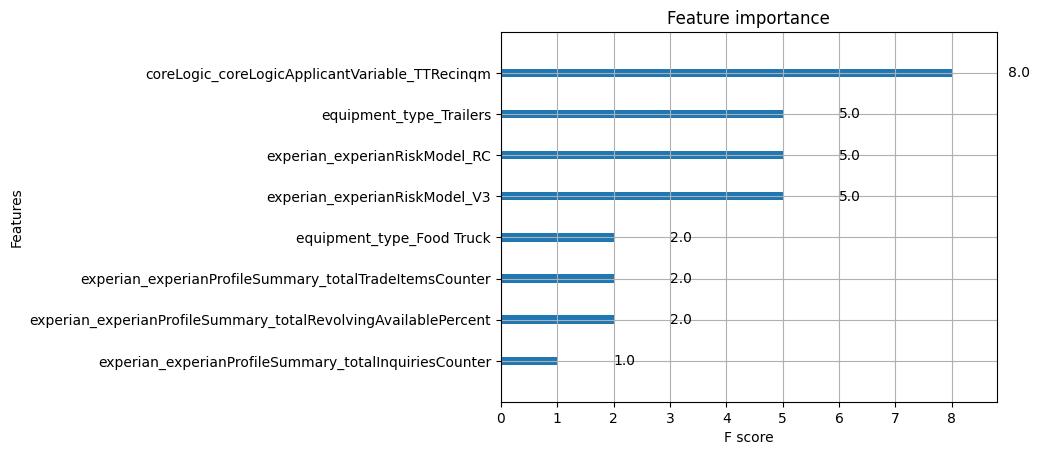

In [9]:
xgb.plot_importance(model, importance_type='weight')


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

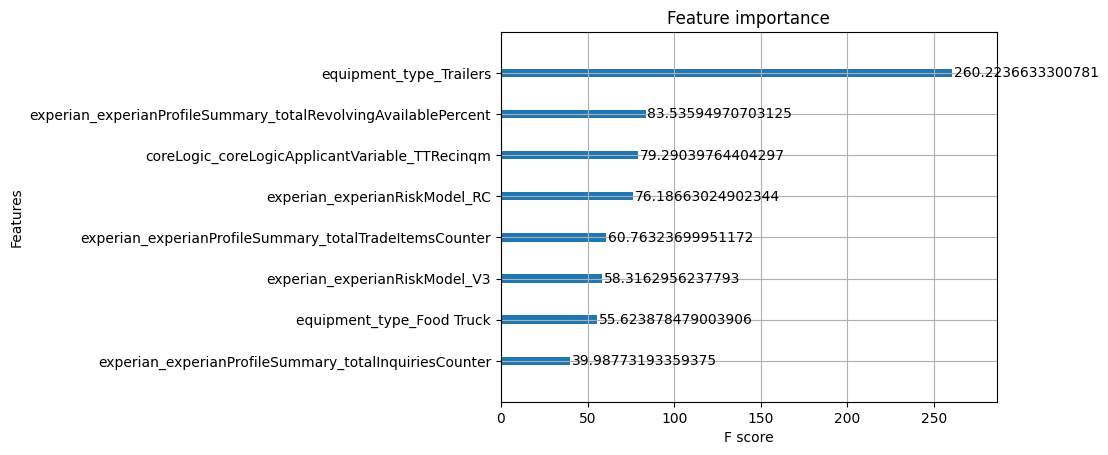

In [10]:
xgb.plot_importance(model, importance_type='gain')

In [11]:
# for i in range(10):
#   fig, ax = plt.subplots(figsize=(90, 90))
#   xgb.plot_tree(model, num_trees=i, ax=ax)
#   plt.show()

In [12]:
roc_auc_score(y, y_pred)

np.float64(0.7772671023434862)